# $P_{ISI}$ in Bifurcation Graph Ko

In [1]:

### Importing packages and functions
import sys
import os
# os.environ['AUTO_DIR'] = '/home/susana/Documents/AUTO_tutorial/auto-07p'
#### This should be set as the path of auto in your own computer, if you didn't add the path to your bashrc file
# os.environ['AUTO_DIR'] = '/path2auto/auto-07p'
import numpy as np
import pylab, json, sympy, scipy
import matplotlib
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc
from copy import copy
### Importing created functions to load model
from m_generic_neuron_from_json import generic_neuron_from_json
from m_generic_neuron_from_json import load_mod
### Something for sympy to work with python 3
from sympy import S
from operator import itemgetter
### to create temp files in every run
import contextlib
import tempfile
import shutil
### Import auto stuff
import autoutils
import auto
### Linear algebra
from sympy.utilities.lambdify import lambdify
from numpy import linalg as LA


In [17]:
## Hack for auto to work
%load_ext autoreload
%autoreload 2

In [18]:
# This is to run auto related stuff in a temporary folder (files are created in every run, and are not needed later)
@contextlib.contextmanager
def TemporaryDirectory(suffix="", prefix="tmp", dir=None):
    name = tempfile.mkdtemp(suffix, prefix, dir)
    try:
        yield name
    finally:
        shutil.rmtree(name)

In [2]:
# This is to save the data used to draw the bifurcation diagram
import pickle
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

dir_sims='./Data/'

In [3]:
def saving_pdf_figure(fig,fig_name,md_dir,raster=False):
    from matplotlib.backends.backend_pdf import PdfPages
    ax=plt.figure()
    ax=fig
    ax2=fig
    pdffig = PdfPages(fig_name+".pdf")
    if raster:
        if raster>1:
            rast=raster
        else:
            rast=300
        ax.savefig(fig_name+'.png',dpi=rast)
        fig.savefig(pdffig, format="pdf",dpi=rast)
    else:
        ax.savefig(fig_name+'.png')
        fig.savefig(pdffig, format="pdf")

    metadata = pdffig.infodict()
    metadata['Title'] = md_dir['Title']
    metadata['Author'] = md_dir['Author']
    metadata['Subject'] = md_dir['Subject']
    metadata['Keywords'] = md_dir['Keywords']
    pdffig.close()

In [4]:
def zoomingBox(ax1, roi, ax2, color='red', linewidth=2, roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=arrowKwargs)

In [5]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_Jacobian(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    return(J)

In [6]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_expressions_and_ss(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    ##############################333##############################333##############################333
    ############## # Running model with ode, to find the steady state to auto as initial conditions   ###########333#
    ##############################333##############################333##############################333
    neuron_fromgen_4sim.changing_pars(bifpar,strIapp=strIapp)
    # Constant input stimuli
    I_exp1 = lambda t: 0 if t<0 else autobifpart[strIapp]
    t=np.linspace(0, 1000.0, 1000.0/0.01)
    # Running ODE
    s_results, v_results=neuron_fromgen_4sim.stimulate_neuron(t,neuron_fromgen_4sim.current_state,I_exp1)
    inivals = ([float(v_results[:,s_results.index(j)][-1]) for j in var])
    return var,rhs,spikecriterion,J,inivals

def extracting_phase_plane_info(ss,lc,J):
    ## Limir cycle info
    v_I_app_lc=[]
    v_one_sim_s_lc=[]
    v_one_sim_lc=[]
    for lc_Iapp_specfi in lc:
        one_sim=[]
        one_sim_s=[]
        for i_s in lc_Iapp_specfi.coordnames:
            one_sim.append(lc_Iapp_specfi[i_s])
            one_sim_s.append(i_s)
        v_I_app_lc.append(lc_Iapp_specfi.PAR[strIapp])
        v_one_sim_s_lc.append(one_sim_s)
        v_one_sim_lc.append(one_sim)
    ## Extracting information from auto objects into numpy arrays
    # steady states
    v_Jeival=[]
    v_Jeivect=[]
    v_fixed_point=[]
    v_I_app_ss=[]
    for ao_fixed_point in ss:
        ### Getting position
        fixed_point=ao_fixed_point.coordarray
        ### Getting expressions of Jacobian for the parameters of each ss_I_app_specf
        v_s_par_ssi=[(k,v) for k,v in ao_fixed_point.PAR.items()]
        J = [[j.subs(v_s_par_ssi) for j in k] for k in J]
        Jfoo = lambdify(ao_fixed_point.coordnames,J)
        Jmat=Jfoo(*fixed_point)
        m_JMat=fixing_jmat(Jmat)
        Jeival, Jeivect = LA.eig(m_JMat)
        v_fixed_point.append(fixed_point)
        v_Jeival.append(Jeival)
        v_Jeivect.append(Jeivect)
        v_I_app_ss.append(ao_fixed_point.PAR[strIapp])
        
    return v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,v_Jeival,v_Jeivect,v_fixed_point
        
    
def extracting_left_eigenvectors(ss,lc,J):
    ## Limir cycle info
    v_I_app_lc=[]
    v_one_sim_s_lc=[]
    v_one_sim_lc=[]
    for lc_Iapp_specfi in lc:
        one_sim=[]
        one_sim_s=[]
        for i_s in lc_Iapp_specfi.coordnames:
            one_sim.append(lc_Iapp_specfi[i_s])
            one_sim_s.append(i_s)
        v_I_app_lc.append(lc_Iapp_specfi.PAR[strIapp])
        v_one_sim_s_lc.append(one_sim_s)
        v_one_sim_lc.append(one_sim)
    ## Extracting information from auto objects into numpy arrays
    # steady states
    v_Jeival=[]
    v_Jeivect=[]
    v_saddle_point=[]
    v_I_app_ss=[]
    for ao_saddle_point in ss:
        ### Getting position
        saddle_point=ao_saddle_point.coordarray
        ### Getting expressions of Jacobian for the parameters of each ss_I_app_specf
        v_s_par_ssi=[(k,v) for k,v in ao_saddle_point.PAR.items()]
        J = [[j.subs(v_s_par_ssi) for j in k] for k in J]
        Jfoo = lambdify(ao_saddle_point.coordnames,J)
        Jmat=Jfoo(*saddle_point)
        m_JMat=fixing_jmat(Jmat)
        Jeival, Jeivect = LA.eig(np.matrix(m_JMat).transpose())
        v_saddle_point.append(saddle_point)
        v_Jeival.append(copy(Jeival))
        v_Jeivect.append(copy(Jeivect))
        v_I_app_ss.append(ao_saddle_point.PAR[strIapp])
        
    return v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,v_Jeival,v_Jeivect,v_saddle_point,m_JMat


In [130]:
from scipy.optimize import curve_fit

# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto
def get_expressions(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    return var,rhs,spikecriterion,J

def func_lambdas(l0,bifpar,autobifpart,saddle,stable,limit_cycle):
    ################################################
    ###### Getting lambdas (eigenvalues) in each stable state (the lambda corresponding to l0..)
    ################################################
    lam_st=[]
    lam_lc=[]

    var,rhs,spikecriterion,J=get_expressions(neuron_snap,bifpar,autobifpart)
    dd={}
    iic=0
    for iis in var:
        dd[iis]=str(stable[iic][0])
        iic+=1

    matJ_stable=np.zeros(np.shape(J))
    for iii in range(np.shape(J)[0]):
        for jjj in range(np.shape(J)[1]):
            matJ_stable[iii][jjj]=S(str(S(str(J[iii][jjj])).subs(autobifpart))).subs(dd) 
    
    dd={}
    iic=0
    for iis in var:
        dd[iis]=str(saddle[iic][0])
        iic+=1

    matJ_saddle=np.zeros(np.shape(J))
    for iii in range(np.shape(J)[0]):
        for jjj in range(np.shape(J)[1]):
            matJ_saddle[iii][jjj]=S(str(S(str(J[iii][jjj])).subs(autobifpart))).subs(dd) 
            
    ii_min=np.argmin(np.dot(l0,limit_cycle-saddle)) 
    ll=limit_cycle[:,ii_min]

    dd={}
    iic=0
    for iis in var:
        dd[iis]=str(ll[iic])
        iic+=1

    matJ_lc=np.zeros(np.shape(J))
    for iii in range(np.shape(J)[0]):
        for jjj in range(np.shape(J)[1]):
            matJ_lc[iii][jjj]=S(str(S(str(J[iii][jjj])).subs(autobifpart))).subs(dd)

    lam_st=LA.eig(matJ_stable)[0][np.argmax(LA.eig(matJ_saddle)[0])]
    lam_lc=LA.eig(matJ_lc)[0][np.argmax(LA.eig(matJ_saddle)[0])]
    
    return lam_st,lam_lc

## Now to normalize the PRC
Where change of phase over time is defined as:

\begin{equation}
    \frac{d\phi}{dt}= f_o +z(\phi)p(t)
\end{equation}

\begin{equation}
    \frac{d\phi}{dt}= \frac{d\phi}{dx} \frac{dx}{dt}
\end{equation}


\begin{equation}
    \frac{dx}{dt}= f(x)+p(t)
\end{equation}

\begin{equation}
    \frac{d\phi}{dt}= \frac{d\phi}{dx} (f(x)+p(t))
\end{equation}

\begin{equation}
    z(\phi)= \frac{d\phi}{dx} 
\end{equation}

\begin{equation}
    \frac{d\phi}{dt}= z(\phi)f(x)+z(\phi)p(t)
\end{equation}

The natural frequency is given by:

\begin{equation}
    f_o=z(\phi)f(x)
\end{equation}


Then, a normalized PRC would have
\begin{equation}
    \frac{z(\phi)f(x)}{f_o}=1
\end{equation}

## Normalizing $z(\phi)$

Now, if $z(\phi)f(x)$ is not equal to $f_o$, we need to find out what is the ratio of it scale $z(\phi)$

### Finding out 

\begin{equation}
    z(\phi)f(x)
\end{equation}

In [19]:
def get_normalized_PRC(model_name,bifpar,v_one_sim_s_lc,limit_cycle):
    import brian2
    import brianutils
    from brianutils import units
    from brianutils import load_model
    ## to calculate PRC Z_o(\varphi)
    ### loading ODE from model_name with parameters given in bifpar
    model= json.load(open("./cfg/"+model_name+".json"))
    if bifpar!=[]:
        for key_bifpar in bifpar.keys():
            model['parameters'][key_bifpar]=bifpar[key_bifpar][0]
    
    ode = load_model(model, {})
    ### Initializing the orbit in the stable limit cycle
    d_ini_states=model['init_states']
    cc_k=0
    for k in v_one_sim_s_lc[0]:
        if k=='v':
            d_ini_states[k]=str(np.array(limit_cycle)[:,0][cc_k])+'*mV'
        else:
            d_ini_states[k]=str(np.array(limit_cycle)[:,0][cc_k])
        cc_k+=1
    
    orb0= brianutils.flow(ode,".3*second",init=d_ini_states,dt="0.01*ms")
    var=ode.diff_eq_names
    inistates=dict([(si_var,'('+str(orb0[si_var][-1][0])+')') for si_var in var])
    ### Changing initial states to the correct format
    jj=[ii for ii in inistates if 'mV' in inistates[ii]]
    vv=inistates[jj[0]].find('mV')
    inistates[jj[0]]=inistates[jj[0]][0:vv-1]+'*'+inistates[jj[0]][vv:]
    ## Running the trace for shorter time, but starting in a sequred a steady state
    orb= brianutils.flow(ode,".1*second",init=inistates,dt="0.01*ms")
    ## Getting a solution to the adjoint first variation of an ODE
    adstates=brianutils.adjoint_linear_flow(ode,".1*second",init=inistates,dt="0.01*ms")
    ## Finding indices where there where spikes
    spk_indices=brianutils.get_spikeIndices(orb["v"], threshold = "-20 * mV")
    av_period=np.mean(np.diff(orb['t'][spk_indices]))
    indexRange=[spk_indices[4],spk_indices[5]]
    #### Importing units to substitute later..
    baseunits2 = [('mV', 1), ('ms', 1),('second', 1), ('cm2', 1), ('cm3', 1), ('uF', 1), ('psiemens', 1), ('um2', 1), ('msiemens', 1), ('cm', 1), ('kelvin', 1), ('mM', 1), ('mol', 1), ('uA', 1), ('mjoule', 1), ('coulomb',1), ('ufarad',1), ('mvolt',1)]
    units= dict(
                list(vars(brian2.units).items())
               +list(vars(brian2.units.allunits).items())
               +list(vars(brian2.units.fundamentalunits).items())
               )
    ##### Getting the right hand side expressions to calculate f(x)
    var,rhs= zip(*ode.eq_expressions)
    sortedOrb = [orb[variable] for variable in var]
    sortedOrb[var.index("v")] = sortedOrb[var.index("v")]/eval("1 * mV",units)  # add additional variable with normalized voltage dimension to fit the replacement {'v/mV':additionalVar} done below
    rhsEvaluatedDict = {}
    for i, equ in enumerate(rhs):
        equStr = str(sympy.S(equ).subs(baseunits2))
        equFct = sympy.lambdify(var, S(equStr))
        rhsEvaluatedDict[var[i]] =np.array([value for value in equFct(*sortedOrb)])      # the star unpacks list into separate python variables. brian2.Quantities ensures that units are kept
    
    ### Extracting out z(\phi) and x
    reducedFlow = {}
    reducedAdjoint = {}
    for variable in ode.eq_names:
        reducedFlow[variable] = orb[variable].flatten()
        reducedAdjoint["ad"+variable] = adstates["ad"+variable].flatten()
    
    ### Extracting out z(\phi) and x
    reducedFlow = {}
    reducedAdjoint = {}
    for variable in ode.eq_names:
        reducedFlow[variable] = orb[variable].flatten()
        reducedAdjoint["ad"+variable] = adstates["ad"+variable].flatten()
    
    variable='v'
    reducedFlow[variable]=reducedFlow[variable]/eval("1 * mV",units)
    reducedAdjoint["ad"+variable]=reducedAdjoint["ad"+variable]*eval("1 * mV",units)
    ## Calculating z(\phi)f(x)
    rhsEvaluated=rhsEvaluatedDict
    ZdotF = np.zeros(rhsEvaluated[variable][:,0].shape) * (reducedAdjoint["ad"+variable][0] * rhsEvaluated[variable][0])
    for variable in ode.eq_names:
        # this implements a dot product over the different state variables for every time point.
        ZdotF += reducedAdjoint["ad"+variable] * rhsEvaluated[variable][:,0]     # returns ZdotF depending on time
    #     print(variable, reducedAdjoint["ad"+variable][:3], rhsEvaluated[variable][:3], ZdotF[:3])
    
    print("Check: Are the following values all eqaul? ZdotF = ", ZdotF[::len(ZdotF)//30]) # those values should all be the same, but the first and last values are different
    periodUnitless = av_period/eval("1 * ms",units)
    ZdotFunitless = ZdotF
    ZdotFvalue = np.mean(ZdotFunitless[int(len(ZdotF)*0.1):int(len(ZdotF)*0.9)])
    PRC = {}
    for key in ode.eq_names:
        PRC[key] = reducedAdjoint["ad"+key][indexRange[0]:indexRange[1]]/(ZdotFvalue*periodUnitless)
    return PRC,periodUnitless,ZdotF,reducedFlow,reducedAdjoint,ode

# Defining setup for the continuations

### Defining neuron model

In [7]:
## Loading neuron model (file in the cfg folder)
model_name='MTM_W_sPNAs_Temp_snapshot_p0'
### How is the applied current parameter called
strIapp='I_app'
### creating a class neuron from m_generic_neuron_from_json that clasifies the expressions for ode
neuron_snap=generic_neuron_from_json(model_name+'.json',strIapp=strIapp)


### Extracting Bif graph information from saved object

In [8]:
### Importing data that created the bif graph
dir_sims='./Data/'
name='Bifurcation_Graph_Iapp_Ko_'+model_name
f=open(dir_sims+name+'.pkl', 'rb')
d_Bif_graph_data=pickle.load(f)

v_s_par=d_Bif_graph_data['Bif_parameters']
v_s_var=d_Bif_graph_data['state_pars']
m_res_par_sn_KoIapp=d_Bif_graph_data['saddle_node_par']
m_res_statev_sn_KoIapp=d_Bif_graph_data['saddle_node_var']
m_res_par_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_par']
m_res_statev_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_var']
m_res_par_HF0=d_Bif_graph_data['Hopf_par']
m_res_statev_HF=d_Bif_graph_data['Hopf_var']

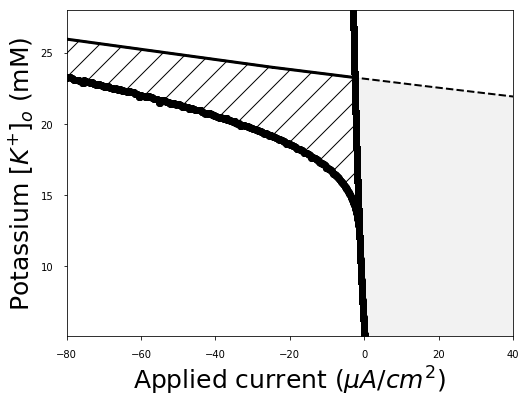

In [10]:
from scipy.interpolate import interp1d
size_axis_font=25
plt.close("all")

fig01 = plt.figure(facecolor="1",figsize=(8,6))
axx = fig01.add_subplot(111)
xlim=[-80,40]
ylim=[5.1,28]
axx.set_xlim(xlim)
axx.set_ylim(ylim)

s_x=1;s_y=0
##### plot sn disappearance, hopf and limit cycle onset
axx.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=2,color=[0,0,0])

##### Drawing the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)

##### filling the different regions
axx.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/",lw=3., edgecolor='k')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axx.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='k',alpha=.05)

##### Plot axes
axx.set_ylabel('Potassium $[K^{+}]_o$ (mM)',fontsize=size_axis_font)
axx.set_xlabel('Applied current $(\mu A/cm^2)$',fontsize=size_axis_font)
axx.tick_params(axis='y', pad=10)
axx.tick_params(axis='x', pad=10)
plt.show()


# Now we want to extract phase planes in each of the regions

### First we extract the limit cycle for a SNIC region, to check the inverse gaussian approximation

In [20]:
## Applied currents in which we are interested
# t_I_app_specf=[-1.23, -1.27,  0.73]
# t_I_app_specf=[ -1.6 ,-1.44,  0.58]
t_I_app_specf=[-2.32,-1.66,0.42]
##############################################3
### Finding phase plane in the bistable region
I_app=-30;K_o=14.0
## Defining Bifurcation parameters.. (In our case I_app and Ko)
bifpar={}
autobifpart={}
bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
autobifpart[strIapp]=I_app
bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
autobifpart['K_o']=K_o
### Extracting inistates & expressions
var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(neuron_snap,bifpar,autobifpart)
cwd_nonTemp = os.getcwd()
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    #############################################################
    ##### Using AUTO to Continue steady state
    # Continuing Forward (ds>0) in I_app   
    r1_fwd_sn_I_app_specf= auto.run(inivals, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
        PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
        DS= 1 * 1e-3, DSMAX= 1 * 1e-2,UZR={strIapp: t_I_app_specf}, STOP=['HB'],
        UZSTOP= {})
    
os.chdir(cwd_nonTemp)

WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
 [py.warnings]


initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -30, 2: 14.0, 11: 0}
For fix point continuation AUTO requires:
2=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1        2  -1.96875E+01   2.41305E+02  -2.41303E+02   4.36194E-18   4.60665E-21   1.00000E+00
   1     2        3  -9.37143E+00   1.41840E+02  -1.41836E+02   1.08509E-08   2.54038E-10   1.00000E+00
   1  6839  UZ    4  -2.32000E+00   7.38475E+01  -7.38407E+01   1.16411E-02   3.4062

In [21]:
s1HB = r1_fwd_sn_I_app_specf('HB')[0]
################# continuing orbit #######################
### Starting from the hopf point backwards (ds<0) in I_app until the onset of spiking is reached..
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    r1_period0_I_app_specf = auto.run(s1HB, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp,'period'], ILP=1, ISW=1,IPS=2,
        ITNW=17, NWTN=13, NMX=100000, NPR=3000,
        DS=-1e-2, DSMIN=-1e-3, DSMAX=-1e-1,UZR= {'I_app': t_I_app_specf},
        SP=['BT','LP','HB','BP','CP'],
        UZSTOP={'period': 100,'I_app': t_I_app_specf[0]-0.1})
    
os.chdir(cwd_nonTemp)


initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -30, 2: 14.0, 11: 0}
For fix point continuation AUTO requires:
2=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM        MAX v        MAX n_K       MAX m_Na      MAX h_Na       period    
  21     3  BP   32   3.51671E+02   3.74644E+01  -3.74391E+01   6.16183E-01   6.17401E-01   1.26609E-01   1.28116E+00
  21  3000       33   5.29576E+01   4.67339E+01  -8.23193E-02   6.07315E-01   9.77764E-01   2.55211E-01   1.81088E+00
  21  3549  UZ   34   4.20000E-01   5.4341

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


In [22]:
## Extracting all the steady states and limit cycle onsets for the applied currents t_I_app_specf
ss_I_app_specf=r1_fwd_sn_I_app_specf.getLabel('UZ')
lc_Iapp_specf=r1_period0_I_app_specf.getLabel('UZ')

In [23]:
## Extracting information from auto objects into numpy arrays
# Limit cycles
v_I_app=[]
v_one_sim_s=[]
v_one_sim=[]
v_period_auto=[]
for lc_Iapp_specfi in lc_Iapp_specf:
    one_sim=[]
    one_sim_s=[]
    for i_s in lc_Iapp_specfi.coordnames:
        one_sim.append(lc_Iapp_specfi[i_s])
        one_sim_s.append(i_s)
    v_I_app.append(lc_Iapp_specfi.PAR[strIapp])
    v_period_auto.append(lc_Iapp_specfi.PAR['period'])
    v_one_sim_s.append(one_sim_s)
    v_one_sim.append(one_sim)


In [24]:
# Function to adjust Jmat dimensions
def fixing_jmat(Jmat):
    m_JMat = [[0 for x in range(len(Jmat))] for y in range(len(Jmat))]
    for i in range(len(Jmat)):
        for j in range(len(Jmat)):
            if 'array' in str(type(Jmat[i][j])):
                m_JMat[i][j]=Jmat[i][j]
            else:
                m_JMat[i][j]=np.array([Jmat[i][j]])
    
    m_JMat = [np.concatenate(j) for j in m_JMat]
    return m_JMat

In [25]:
from sympy.utilities.lambdify import lambdify
from numpy import linalg as LA
## Extracting information from auto objects into numpy arrays
# steady states
v_Jeival=[]
v_Jeivect=[]
v_saddle_point=[]
v_I_app_ss=[]
for ao_saddle_point in ss_I_app_specf:
    ### Getting position
    saddle_point=ao_saddle_point.coordarray
    ### Getting expressions of Jacobian for the parameters of each ss_I_app_specf
    v_s_par_ssi=[(k,v) for k,v in ao_saddle_point.PAR.items()]
    J = [[j.subs(v_s_par_ssi) for j in k] for k in J]
    Jfoo = lambdify(ao_saddle_point.coordnames,J)
    Jmat=Jfoo(*saddle_point)
    m_JMat=fixing_jmat(Jmat)
    Jeival, Jeivect = LA.eig(m_JMat)
    v_saddle_point.append(saddle_point)
    v_Jeival.append(Jeival)
    v_Jeivect.append(Jeivect)
    v_I_app_ss.append(ao_saddle_point.PAR[strIapp])

# Results: Phase planes in each of the regions

-2.32
-2.32
-1.66
0.42


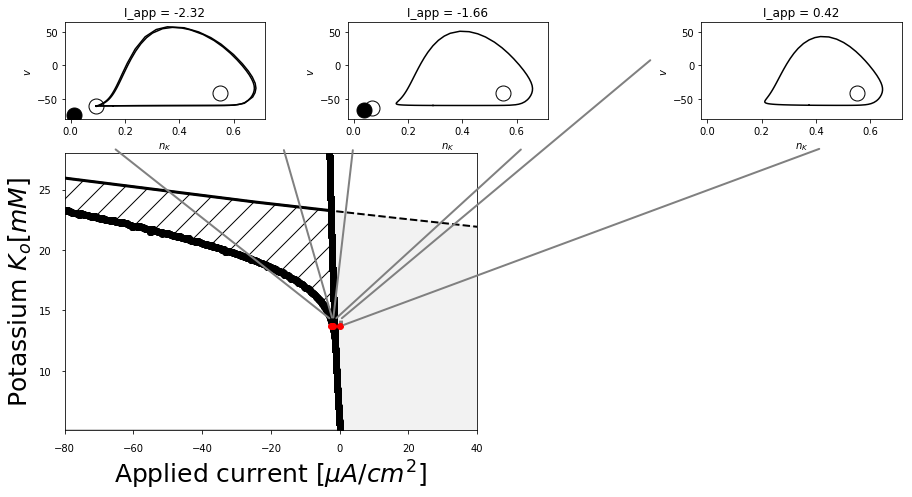

In [26]:
plt.close("all")
fig01 = plt.figure(facecolor="1",figsize=(15,7.5))
axpl = plt.subplot2grid((50,12), (16, 0), colspan=6,rowspan=34)
ax1l = plt.subplot2grid((50,12), (0, 0), colspan=3,rowspan=12)
ax1m = plt.subplot2grid((50,12), (0, 4), colspan=3,rowspan=12,sharex=ax1l,sharey=ax1l)
ax1r = plt.subplot2grid((50,12), (0, 9), colspan=3,rowspan=12,sharex=ax1l,sharey=ax1l)


xlim=[-80,40]
ylim=[5.1,28]
axpl.set_xlim(xlim)
axpl.set_ylim(ylim)

s_x=1;s_y=0
##### plot sn disappearance, hopf and limit cycle onset
axpl.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],'o',color=[0,0,0])
axpl.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],'o',color=[0,0,0])
axpl.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=2,color=[0,0,0])

##### Drawing the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)
axpl.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/",lw=3., edgecolor='k')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axpl.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='k',alpha=.05)
##### Plot axes
axpl.set_ylabel('Potassium $K_o[mM]$',fontsize=size_axis_font)
axpl.set_xlabel('Applied current $[\mu A/cm^2]$',fontsize=size_axis_font)
axpl.tick_params(axis='y', pad=10)
axpl.tick_params(axis='x', pad=10)


###### Phase planes

ax=[ax1l,ax1m,ax1r]

for ii_iapi in range(len(t_I_app_specf)):
    ### Plot limit cycle onset
    ax[ii_iapi].set_title(strIapp+' = '+ str(t_I_app_specf[ii_iapi]))
    for ii_api_lc in range(len(v_I_app)):
        if abs(v_I_app[ii_api_lc]-t_I_app_specf[ii_iapi])<0.1:
            try:
                print(t_I_app_specf[ii_iapi])
                ax[ii_iapi].plot(v_one_sim[ii_api_lc][1],v_one_sim[ii_api_lc][0],color='black')
            except:
                pass
    ### Plot ss
    for ii_api_ss in range(len(v_I_app_ss)):
        if abs(v_I_app_ss[ii_api_ss]-t_I_app_specf[ii_iapi])<0.1:
            if any(v_Jeival[ii_api_ss].real>0):
                ax[ii_iapi].plot(v_saddle_point[ii_api_ss][1],v_saddle_point[ii_api_ss][0],'o',markersize=15,mfc='none',color='black')
            else:
                ax[ii_iapi].plot(v_saddle_point[ii_api_ss][1],v_saddle_point[ii_api_ss][0],'o',markersize=15,color='black')

    ax[ii_iapi].set_ylabel('$'+v_one_sim_s[0][0]+'$')
    ax[ii_iapi].set_xlabel('$'+v_one_sim_s[0][1]+'$')
    axpl.plot(t_I_app_specf[ii_iapi]-0.25,K_o-0.25,'o',color='r')
    zoomingBox(axpl, np.array([t_I_app_specf[ii_iapi]-0.25,t_I_app_specf[ii_iapi]+0.25,K_o-0.25,K_o+0.25]), ax[ii_iapi],color='grey')



    
    
# fig_name='Phase_diagrams_BistablePlane_'+model_name+'K_o_'+bifpar['K_o'][0][1:bifpar['K_o'][0].index('*')]+'_Iapp_'+str(int(t_I_app_specf[0]))+'_'+str(int(t_I_app_specf[1]))+'_'+str(int(t_I_app_specf[2]))
# md_dir={}
# md_dir['Title']='phase diagrams in bistable region'+model_name
# md_dir['Author']= 'Susana Contreras'
# md_dir['Subject']='stochastic bursting'
# md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

# saving_pdf_figure(fig01,'./Figs/'+fig_name,md_dir)
# plt.show()
# fig_name

# Results: PRCs in each of the regions

In [27]:
v_I_app

[0.41999997115, -1.6600000023, -2.3200002151, -2.3543442049]

In [28]:
t_I_app_specf

[-2.32, -1.66, 0.42]

-2.32
{'I_app': ['-2.3200002151* uA/cm2'], 'K_o': ['(14.0*mM)']}
Check: Are the following values all eqaul? ZdotF =  [ 0.00550662  0.00620912  0.00623172  0.00621991  0.00697626  0.007021
  0.00701068  0.00785319  0.00792933  0.00792014  0.00882706  0.00893716
  0.00892894  0.00994105  0.01008111  0.01007379  0.01121549  0.01138131
  0.01137489  0.01262337  0.01280799  0.01280264  0.01311308  0.01456153
  0.01455697  0.01983411  0.01578468  0.01578274 -0.06595823  0.02190798
  0.02190605]
Time=28.249314069747925
-2.32
{'I_app': ['-2.3543442049* uA/cm2'], 'K_o': ['(14.0*mM)']}
-1.66
{'I_app': ['-1.6600000023* uA/cm2'], 'K_o': ['(14.0*mM)']}
Check: Are the following values all eqaul? ZdotF =  [0.28252467 0.27356304 0.27504777 0.27211979 0.27522688 0.27643012
 0.27503823 0.27689129 0.28766058 0.2768997  0.27845646 0.27471857
 0.27859262 0.27984771 0.27831176 0.28027945 0.28376169 0.28027232
 0.28189943 0.27678256 0.28199944 0.28332117 0.28159037 0.28370712
 0.27712625 0.28367961 0.2853764

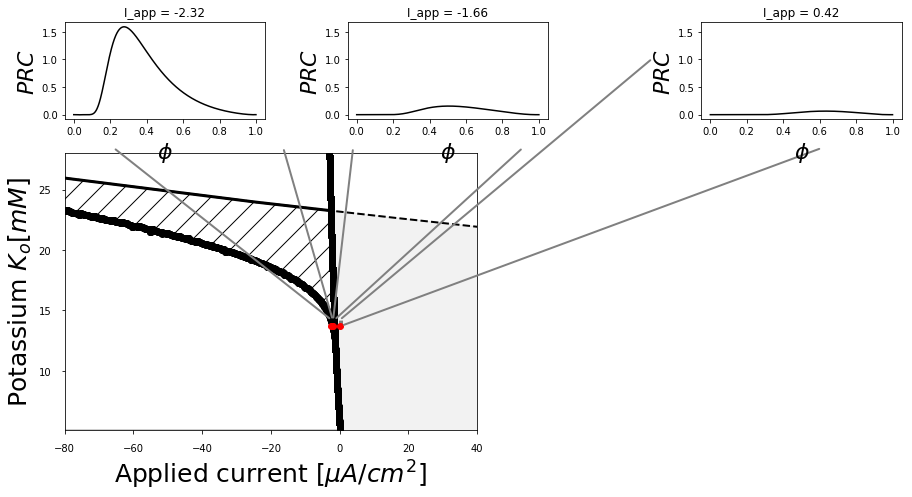

'PRC_BistablePlane_MTM_W_sPNAs_Temp_snapshot_p0K_o_14.0_Iapp_-2_-1_0'

In [29]:
import time
plt.close("all")
fig01 = plt.figure(facecolor="1",figsize=(15,7.5))
axpl = plt.subplot2grid((50,12), (16, 0), colspan=6,rowspan=34)
ax1l = plt.subplot2grid((50,12), (0, 0), colspan=3,rowspan=12)
ax1m = plt.subplot2grid((50,12), (0, 4), colspan=3,rowspan=12,sharex=ax1l,sharey=ax1l)
ax1r = plt.subplot2grid((50,12), (0, 9), colspan=3,rowspan=12,sharex=ax1l,sharey=ax1l)


xlim=[-80,40]
ylim=[5.1,28]
axpl.set_xlim(xlim)
axpl.set_ylim(ylim)

s_x=1;s_y=0
##### plot sn disappearance, hopf and limit cycle onset
axpl.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],'o',color=[0,0,0])
axpl.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],'o',color=[0,0,0])
axpl.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=2,color=[0,0,0])

##### Drawing the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)
axpl.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/",lw=3., edgecolor='k')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axpl.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='k',alpha=.05)
##### Plot axes
axpl.set_ylabel('Potassium $K_o[mM]$',fontsize=size_axis_font)
axpl.set_xlabel('Applied current $[\mu A/cm^2]$',fontsize=size_axis_font)
axpl.tick_params(axis='y', pad=10)
axpl.tick_params(axis='x', pad=10)
###### Phase planes
ax=[ax1l,ax1m,ax1r]
a_PRC=[]
a_avgperiod=[]
a_autoperiod=[]
a_Zdot=[]
temp_Iapp=[]
for ii_iapi in range(len(t_I_app_specf)):
    ### Plot limit cycle onset
    ax[ii_iapi].set_title(strIapp+' = '+ str(t_I_app_specf[ii_iapi]))
    for ii_api_lc in range(len(v_I_app)):
        if abs(v_I_app[ii_api_lc]-t_I_app_specf[ii_iapi])<0.1:
            try:
                print(t_I_app_specf[ii_iapi])
                bifpar={}
                bifpar[strIapp] = [str(v_I_app[ii_api_lc])+"* uA/cm2"]
                bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
                print(bifpar)
                st=time.time()
                PRC,periodUnitless,zDot,reducedFlow,reducedAdjoint,ode=get_normalized_PRC(model_name,bifpar,v_one_sim_s[ii_api_lc],v_one_sim[ii_api_lc])
                a_Zdot.append(zDot)
                a_PRC.append(PRC)
                a_avgperiod.append(periodUnitless)
                a_autoperiod.append(v_period_auto[ii_api_lc])
                temp_Iapp.append(t_I_app_specf[ii_iapi])
                ax[ii_iapi].plot(np.linspace(0,1,len(PRC["v"])),PRC["v"],color='black')
                print('Time='+str(time.time()-st))
            except:
                a_PRC.append([])
                a_avgperiod.append([])
                a_autoperiod.append([])
                temp_Iapp.append(t_I_app_specf[ii_iapi])
                pass
    ax[ii_iapi].set_ylabel('$PRC$',fontsize=size_axis_font-3)
    ax[ii_iapi].set_xlabel('$\phi$',fontsize=size_axis_font-3)
    axpl.plot(t_I_app_specf[ii_iapi]-0.25,K_o-0.25,'o',color='r')
    zoomingBox(axpl, np.array([t_I_app_specf[ii_iapi]-0.25,t_I_app_specf[ii_iapi]+0.25,K_o-0.25,K_o+0.25]), ax[ii_iapi],color='grey')

    
fig_name='PRC_BistablePlane_'+model_name+'K_o_'+bifpar['K_o'][0][1:bifpar['K_o'][0].index('*')]+'_Iapp_'+str(int(t_I_app_specf[0]))+'_'+str(int(t_I_app_specf[1]))+'_'+str(int(t_I_app_specf[2]))
md_dir={}
md_dir['Title']='phase diagrams in bistable region'+model_name
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

# saving_pdf_figure(fig01,'./Figs/'+fig_name,md_dir)
plt.show()
fig_name

#  ISI (inverse gaussian in the snic region of regular spiking -> Iapp> threshold)

# $ p_{lc} = \frac{\exp(-\frac{(t-\tau_{lc})^2}{\tau_{lc}^2 2 D_{lc} t})}{\sqrt{\pi 2 D_{lc} t^3}} $


## Where..

## 1.1  $\tau_{lc}$ is the natural period of the limit cycle, and Dlc is the effective diffusion matrix. 

## Dlc Given by:

## $D_{lc} = \int_{0}^{1} d\varphi Z_o(\varphi) \cdot D(x_{lc}(\varphi))Z_o(\varphi)$

Where $Z_o(\varphi)$ is the phase response curve

## In our case :

## $D_{lc} = \int_{0}^{1} d\varphi Z_o(\varphi) \cdot \begin{vmatrix}
\mathbf{\sigma_{inp}^2} & 0 & 0 & 0\\
0 &  0 & 0 & 0\\
0 &  0 & 0 & 0
\end{vmatrix}     
Z_o(\varphi)$

## 1.2 $D_{lc} =\sigma_{inp}^2\int_{0}^{1} d\varphi Z_o(\varphi)^2$

## lets say $\beta_dot =\int_{0}^{1} d\varphi Z_o(\varphi)^2$

## Then $D_{lc} = \beta \sigma_{inp}^2$

# $ p_{lc} =  \frac{exp(-\frac{(t-\mu)^2}{(\mu^2 \beta 2 \sigma^2 t)}}{\sqrt{ \pi \beta 2 \sigma^2 t^3 }}$

In [30]:
### Loading simulation data
sigi=1.0
time_stim=20000
ge_amp=0
gi_amp=0
    
iapp='I_app'
ko='K_o'
Koi_bifparx=14
if Koi_bifparx-int(Koi_bifparx)==0:
    stringi=ko+'_'+str(int(Koi_bifparx))+'_'
else:
    Koi_bifparx_aux=int((Koi_bifparx-int(Koi_bifparx))*100)
    stringi=ko+'_'+str(int(Koi_bifparx))+'_'+str(Koi_bifparx_aux)+'_'

# stringi=stringi+iapp+'_'+str(int(float(v_I_app[ii_api_lc])*100))
stringi=stringi+iapp+'_'+str(int(float(0.42)*100))
if sigi-int(sigi)==0:
    stringi=stringi+'_sig_'+str(int(sigi))
else:
    sigi_aux=int((sigi-int(sigi))*100)
    stringi=stringi+'_sig_'+str(int(sigi))+'_0'+str(sigi_aux)

stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
stringi=stringi+'_wZoomIn2Volt_pconnect0'

if sigi-int(sigi)==0:
    strSig=str(int(sigi))
else:
    sigi_aux=int((sigi-int(sigi))*100)
    strSig=str(int(sigi))+'_0'+str(sigi_aux)

name='d_ComplAnalysis_PopActivity_vectKos_N_'+str(2000)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_In_Mixing_Factor_Graph_sigma_'+strSig
name=name+stringi

    
#### Unplugged setup

dir_sims_ISI='/extra2/Mixing_factor/Data/'
if os.path.isfile(dir_sims_ISI+name+'.pkl'):
    print('!!! File : '+name+' exists !!!')
    f=open(dir_sims_ISI+name+'.pkl', 'rb')
    d_ComplAnalysis=pickle.load(f)
    ## Basics Simulation
    koivv=d_ComplAnalysis['Ko']
    iapi_v=d_ComplAnalysis['Iapp']
    ii_num_neurons_v=d_ComplAnalysis['n_neurons']
    ## Autocorr PopActivity
    AutoCorr_avg_v=d_ComplAnalysis['Mean_auto_corr']
    ## Brunel Syn idx
    Sync_Index_v=d_ComplAnalysis['STS']
    Fr_v=d_ComplAnalysis['FR']
    ## ISI stats
    a_ISI_pop_v=d_ComplAnalysis['ISI_population']
    Cv_pop_v=d_ComplAnalysis['CV_population']
    ff_pop_v=d_ComplAnalysis['FF_population']
    Cv_dist_v=d_ComplAnalysis['CV_distribution']
    Nspk_pNeuron_v=d_ComplAnalysis['SpikesPerNeuron']
    ## Power spectrum population activity
    f_lfp_v=d_ComplAnalysis['Spectrum_population_f']
    p_lfp_v=d_ComplAnalysis['Spectrum_population_p']
    ## Power spectrum subthreshold activity
    f_i=d_ComplAnalysis['Spectrum_subthreshold_f']
    pv_v_v=d_ComplAnalysis['Spectrum_subthresholdV_p']
    pge_v_v=d_ComplAnalysis['Spectrum_subthresholdge_p']
    pgi_v_v=d_ComplAnalysis['Spectrum_subthresholdgi_p']
    pinp_v_v=d_ComplAnalysis['Spectrum_subthresholdinp_p']
    ## Statssubthreshold activity
    stats_v_v_v=d_ComplAnalysis['Stats_subthresholdV_p']
    stats_ge_v_v=d_ComplAnalysis['Stats_subthresholdge_p']
    stats_gi_v_v=d_ComplAnalysis['Stats_subthresholdgi_p']
    stats_inp_v_v=d_ComplAnalysis['Stats_subthresholdinp_p']
    inp_v_v=d_ComplAnalysis['dyn_input']
    ## raw spike trains
    trains_v_v=d_ComplAnalysis['trains']
    t_trains_v_v=d_ComplAnalysis['t_trains']

!!! File : d_ComplAnalysis_PopActivity_vectKos_N_2000_num_runs_1_lengthSim_20000_In_Mixing_Factor_Graph_sigma_1K_o_14_I_app_42_sig_1ge_0_gi_0_wZoomIn2Volt_pconnect0 exists !!!


In [100]:
##mean ISI, comparing to theory
import sympy, brian2
from numpy.random import rand
from numpy import log, cumsum, linspace, sort, pi
from sympy import S, lambdify, N
# from scipy.interpolate import interp1d
from numpy.random import rand
from brian2 import units
units = vars(units)

## Expression
invgauss = S("exp(-(t-mu)**2/(2*mu**2*beta_c*sig**2*t))/sqrt(2*pi*t**3*beta_c*sig**2)")
exppdf = S("exp(-t/taue)/taue")



In [101]:
ii_api_lc=0
Iapi_analy=v_I_app[ii_api_lc]

for ii in range(len(temp_Iapp)):
    if abs(temp_Iapp[ii]-Iapi_analy)<0.1:
        ii_api_lc_aut=ii

print('Current to be analyzed')
print(Iapi_analy)
### DEfininginverse gaussian properties
print('Average period from deterministic simulation')
print(str(a_avgperiod[ii_api_lc_aut])) ##


### Sanity check auto period calc almost = to average period calculated from simulation 
print('Sanity check auto period calc almost = to average period calculated from simulation ')
print(str(a_avgperiod[ii_api_lc_aut]-a_autoperiod[ii_api_lc_aut]))

##### 1

### 1.1
tau_lc=a_autoperiod[ii_api_lc_aut] ##6.3

### 1.2
PRC=a_PRC[ii_api_lc_aut]
x=np.linspace(0,1,len(PRC["v"]))
y=PRC["v"]*PRC["v"]
beta_c=sum(y)*(1.0-0)/len(x)
D_lc=sigi*beta_c


Current to be analyzed
0.41999997115
Average period from deterministic simulation
3.7936000000000005
Sanity check auto period calc almost = to average period calculated from simulation 
0.00012852380000039076


In [102]:
# Defining escape rate, when there is a fixed point..
v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,rv_Jeival,rv_Jeivect,v_fixed_point=extracting_phase_plane_info(ss_I_app_specf,lc_Iapp_specf,J)
v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,lv_Jeival,lv_Jeivect,v_fixed_point,m_Jmat=extracting_left_eigenvectors(ss_I_app_specf,lc_Iapp_specf,J)

saddle_pos=[]
stable_pos=[]
for ii_api_ss in range(len(v_I_app_ss)):
    if abs(Iapi_analy-v_I_app_ss[ii_api_ss])<0.1:
        if sum(v_Jeival[ii_api_ss].real>0)==1:
            saddle_pos=v_fixed_point[ii_api_ss]
            print('saddle')
            print(saddle_pos)
            El_saddle=lv_Jeivect[ii_api_ss]
            lam_saddle=lv_Jeival[ii_api_ss]
            argsort = [j for j, k in sorted(enumerate(lam_saddle), key=lambda x:x[1], reverse=1)]
            lam = [lam_saddle[k] for k in argsort]
            lam0=lam[0]
            ## Extracting l0 from the left eigenvectors at the saddle node
            l0=np.concatenate(np.array(El_saddle[:,lam_saddle>0]))
        if sum(v_Jeival[ii_api_ss].real>0)==0:
            stable_pos=v_fixed_point[ii_api_ss]
            print('stable')
            print(stable_pos)
            
for ii_api_lc_ii in range(len(v_I_app_lc)):
    ## Extracting info from LC
    if abs(v_I_app_lc[ii_api_lc_ii]-Iapi_analy)<np.diff(t_I_app_specf)[0]/2:
        try:
            one_lc=v_one_sim_lc[ii_api_lc_ii]
        except:
            pass

bifpar={}
bifpar[strIapp] = [str(Iapi_analy)+"* uA/cm2"]
bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
print(bifpar)

par={}
for ii_s in list(bifpar.keys()):
    par[ii_s]=bifpar[ii_s][0]

   
if stable_pos==[]:
    theor_omega=0
    taue_theor=0.01
else:
    sigma_v=[sigi,0,0,0]
    M= json.load(open("cfg/"+model_name+".json"))
    M['parameters'].update(bifpar)
    dlc=min(np.dot(l0,one_lc-saddle_pos))
    taue_theor=tauesc(stable_pos,saddle_pos,par)
    ### Mixing factor theory: See eq (8)
    from scipy.special import erf
    sigma_proj=abs(np.dot(l0,sigma_v))
    theor_omega=1/2*(1-erf(dlc*np.sqrt(lam0)/sigma_proj))

{'I_app': ['0.41999997115* uA/cm2'], 'K_o': ['(14.0*mM)']}


In [103]:
## Parameters
par_invgauss = {"mu": str(tau_lc), "sig": str(sigi),"beta_c":str(beta_c)}
par_both = {"mu": str(tau_lc), "sig": str(sigi),"beta_c":str(beta_c),"taue": str(taue_theor),"w":str(theor_omega)}

## function
invgauss_foo = lambdify("t",S(invgauss.subs(par_invgauss)))
exp_foo = lambdify("t",exppdf.subs(par_both))


def poisson(mean,Nsample=1):
    return -mean*log(rand(Nsample))


def conv_pdf(t):
    from scipy import integrate
    return integrate.quad(lambda r:exp_foo(t-r)*invgauss_foo(r),0,t)[0]

def Pisi_hom(t,par):
    w=par['w']
    return [w*conv_pdf(tk) + (1-w)*invgauss_foo(tk) for tk in t]

### Laplace transform InvGaussian
def Glc(s,par=par_invgauss):
    from numpy import sqrt, exp
    import numpy
    sig = float(par["sig"])
    beta_c=float(par["beta_c"])
    mu = float(par['mu'])
    return exp((1-sqrt(1+s*2*beta_c*sig**2*mu**2))/(beta_c*sig**2*mu))

def G(s,par=par_both):
    from numpy import sqrt, exp
    import numpy
    sig = float(par["sig"])
    beta_c=float(par["beta_c"])
    mu = float(par['mu'])
    tau = float(par['taue'])
    w = float(par['w'])
    Plc = exp((1-sqrt(1+2*s*beta_c*sig**2*mu**2))/(beta_c*sig**2*mu))
    Pe = 1/(1+s*tau)
    return (1-w+w*Pe)*Plc

In [104]:
import json
import matplotlib.ticker as ticker

P= json.load(open("cfg/Thesis_mpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]


Same Iapi
Same Ko


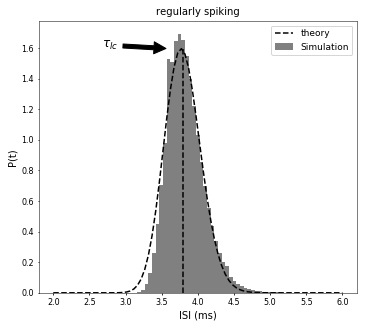

<Figure size 410.4x360 with 0 Axes>

0.0011565628923119857

In [114]:
plt.close("all")

for ii in range(len(koivv)):
    if abs(K_o-koivv[ii])<0.1:
        koii=ii
        
for ii in range(len(iapi_v[koii])):
    if abs(v_I_app[ii_api_lc]-iapi_v[koii][ii])<0.1:
        i_api_ii=ii
        

if abs(iapi_v[koii][i_api_ii]-v_I_app[ii_api_lc])<0.1:
    print('Same Iapi')
if koivv[koii]==K_o:
    print('Same Ko')

# min_pisi=0.01
# max_pisi=20

min_pisi=2
max_pisi=6

Nsamples=80
# theor_dist=invgauss_foo(np.linspace(min_pisi, max_pisi, Nsamples))
theor_dist=invgauss_foo(np.linspace(min_pisi, max_pisi, Nsamples))


f11, ax= plt.subplots(1, sharex=True,sharey=True, facecolor="1")
a0,b0,c0=ax.hist(a_ISI_pop_v[koii][i_api_ii],np.linspace(min_pisi, max_pisi, Nsamples),density='True',label='Simulation',color='grey')


max_theor=max(theor_dist)
ax.plot(np.linspace(min_pisi,max_pisi,Nsamples),theor_dist,'--',label='theory',color='black')
ax.plot([tau_lc, tau_lc],[0,max_theor],'--k')
ax.annotate( r'$ \tau_{lc} $', (tau_lc-0.2,max_theor),xytext=(0.2, 0.9), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05))
# ax.title('$\sigma$='+str(sigi))
ax.set_ylabel('P(t)')
ax.set_xlabel('ISI (ms)')
ax.set_title('regularly spiking')
# ax.set_xlim([0,max_pisi])
# ax.set_xlim([0,8])
ax.legend()

locatory = ticker.MaxNLocator(nbins=3) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory)

locatorx = ticker.MaxNLocator(nbins=3) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locatorx)

# ax.legend(loc='best', bbox_to_anchor=(1, 0.5),prop={'size': size_legend_font})

fig_name='Pt_ISI_SNIC'+'_I_app_'+bifpar['I_app'][0][0:bifpar['I_app'][0].index('*')]+'_K_o_'+bifpar['K_o'][0][1:bifpar['K_o'][0].index('*')]+'_N_'+str(2000)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_In_Mixing_Factor_Graph_sigma_'+strSig
md_dir={}
md_dir['Title']='P(t) theory and simulation SNIC'+model_name
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

saving_pdf_figure(f11,'./Figs/'+fig_name,md_dir)
fig_name

plt.show()
beta_c